In [1]:
import pandas as pd
import numpy as np
import random 

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, mean_absolute_error

import xgboost
import numerapi
NAPI = numerapi.NumerAPI(verbosity="info")
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from bayes_opt import BayesianOptimization
import os
import uuid
import pickle
from sklearn.decomposition import PCA

from helpers.utils import *
from helpers.xgboost_feval import *
DIR = "/Users/brianbroeking/projects/numerai/data"

In [2]:
# Download, unzip and load data
download_current_data(DIR)
train_static, val_static, tournament_static = load_data(DIR, reduce_memory=True)
features_list = generate_features_list(train_static)
# Group stats
train_with_group, val_with_group, tournament_with_group = get_group_stats(train_static), get_group_stats(val_static), get_group_stats(tournament_static)

pca = PCA(0.95, svd_solver='full')
pca.fit(train_with_group[features_list])
res = pca.transform(train_with_group[features_list])

train_with_group_pca = pca.transform(train_with_group[features_list])
val_with_group_pca = pca.transform(val_with_group[features_list])
tournament_with_group_pca = pca.transform(tournament_with_group[features_list])

train_with_group_pca_df = pd.DataFrame(train_with_group_pca)
val_with_group_pca_df = pd.DataFrame(val_with_group_pca)
tournament_with_group_pca_df = pd.DataFrame(tournament_with_group_pca)

pca_train = pd.concat([train_with_group.drop(columns=features_list).reset_index(),
                       train_with_group_pca_df.reset_index()], axis=1)
pca_val = pd.concat([val_with_group.drop(columns=features_list).reset_index(),
                     val_with_group_pca_df.reset_index()], axis=1)
pca_tournament = pd.concat([tournament_with_group.drop(columns=features_list).reset_index(),
                            tournament_with_group_pca_df.reset_index()], axis=1)

pca_train = pca_train.drop(columns=['index'])
pca_val = pca_val.drop(columns=['index'])
pca_tournament = pca_tournament.drop(columns=['index'])

/Users/brianbroeking/projects/numerai/data/numerai_dataset_262.zip:  99%|█████████▉| 399M/402M [00:07<00:00, 54.7MB/s] 2021-05-01 13:15:34,119 INFO numerapi.base_api: unzipping file...


Loading the data


/Users/brianbroeking/projects/numerai/data/numerai_dataset_262.zip: 402MB [00:23, 17.5MB/s]                           
/opt/homebrew/Caskroom/miniforge/base/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [4]:
def era_boost_train(X, y, era_col, proportion=0.5,
                    trees_per_step=10, num_iters=200,
                    one_shot=False, tree_method='hist',
                    test_model=None, note=None):
    print(f"\n#### Era boost train with proportion {proportion:0.3f} ####\n")
    if note is not None:
        print(note)
    if one_shot:
        trees_per_step = trees_per_step * num_iters
        num_iters=1

    if test_model is None:
        print(f"Train {num_iters} iterations")
        print(f"Train {trees_per_step} rounds per iteration")
    else:
        print("Testing model performance")
    features = X.columns
    new_df = X.copy()
    new_df["target"] = y
    new_df["era"] = era_col
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': 25,
        'learning_rate': 0.05,
        'colsample_bytree': 0.1,
        'gamma': 3, # trained at gammas 1,2,.75,.3
        'alpha': 7,
        'lambda': 9,
        'max_depth': 7,
        'min_child_weight': 16
    }
    for i in range(num_iters):
        print(f"\nIteration {i+1}:\n")
        if test_model is None:
            if i==0:
                model = xgboost.XGBRegressor(**params,
                                             n_jobs=-1,
                                             tree_method=tree_method)
                model.fit(X, y)
            else:
                model.n_estimators += trees_per_step
                booster = model.get_booster()
                print("fitting on worst eras")
                model.fit(worst_df[features], worst_df["target"], xgb_model=booster)
        else:
            if i == 0:
                model = test_model
            else:
                model.n_estimators += trees_per_step
                booster = model.get_booster()
                print("fitting on worst eras")
                model.fit(worst_df[features], worst_df["target"], xgb_model=booster)
        # score each era
        print("predicting on train")
        preds = model.predict(X)
        new_df["pred"] = preds
        era_scores = pd.Series(index=new_df["era"].unique())
        print("getting per era scores")
        for era in new_df["era"].unique():
            era_df = new_df[new_df["era"] == era]
            print(spearmanr(era_df["pred"], era_df["target"])[0])
            era_scores[era] = spearmanr(era_df["pred"], era_df["target"])[0]
        era_scores.sort_values(inplace=True)
        worst_eras = era_scores[era_scores <= era_scores.quantile(proportion)].index
        print(list(worst_eras))
        worst_df = new_df[new_df["era"].isin(worst_eras)]
        era_scores.sort_index(inplace=True)
        era_scores.plot(kind="bar")
        print("performance over time")
        plt.show()
        print("autocorrelation")
        print(ar1(era_scores))
#         if (ar1(era_scores)) < 0.1:
#             return model
        print("mean correlation")
        print(np.mean(era_scores))
        print("sharpe")
        print(np.mean(era_scores)/np.std(era_scores))
        print("smart sharpe")
        print(smart_sharpe(era_scores))
    return model

In [ ]:
X_train, y_train = clean_for_xgboost(pca_train)


#### Era boost train with proportion 0.500 ####

Testing model performance

Iteration 1:

predicting on train


<ipython-input-4-7e0f351a00e1>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.03189434920128975
0.029753166257118154
0.009089647280626603
0.07508482606560463
0.05734842503042059
0.03250895112041689
0.0156280131818935
0.03805934949757437
0.013708487544401559
0.04719535290689926
0.05220072270778548
0.03540652260424333
0.017639615079691497
0.02235127241828902
0.037562968477934784
0.07415723758795863
-0.008194354945574927
0.02101559759118039
0.036712465175437546
0.02782353776423808
0.04640600147294927
0.02989208416553116
0.03802412702284568
0.014037237685471025
0.031182430175651865
0.012358897047050873
2.4459912623551512e-05
0.007038367106038118
0.03733849823529034
0.0642852056245886
0.021025506836028284
0.008805481522625341
-0.019569682470009637
0.032318972152163415
0.019674322802177246
0.04617953123213368
0.006584679278547713
0.03748247405437144
0.052516087052308556
0.015048594266028269
-0.003492223627249562
0.029803173966540798
0.005535139169210866
0.03907356062218465
0.061636802743573776
0.021812276763671232
0.07117266907884563
0.0618957

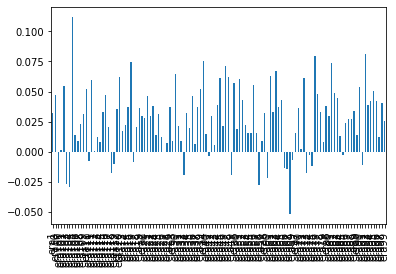

autocorrelation
-0.021344709234446913
mean correlation
0.025860724170231716
sharpe
0.922828173087683
smart sharpe
0.9386371292128654

Iteration 2:

fitting on worst eras
predicting on train


<ipython-input-4-7e0f351a00e1>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.03189434920128975
0.029753166257118154
0.009089647280626603
0.07508482606560463
0.05734842503042059
0.03250895112041689
0.0156280131818935
0.03805934949757437
0.013708487544401559
0.04719535290689926
0.05220072270778548
0.03540652260424333
0.017639615079691497
0.02235127241828902
0.037562968477934784
0.07415723758795863
-0.008194354945574927
0.02101559759118039
0.036712465175437546
0.02782353776423808
0.04640600147294927
0.02989208416553116
0.03802412702284568
0.014037237685471025
0.031182430175651865
0.012358897047050873
2.4459912623551512e-05
0.007038367106038118
0.03733849823529034
0.0642852056245886
0.021025506836028284
0.008805481522625341
-0.019569682470009637
0.032318972152163415
0.019674322802177246
0.04617953123213368
0.006584679278547713
0.03748247405437144
0.052516087052308556
0.015048594266028269
-0.003492223627249562
0.029803173966540798
0.005535139169210866
0.03907356062218465
0.061636802743573776
0.021812276763671232
0.07117266907884563
0.0618957

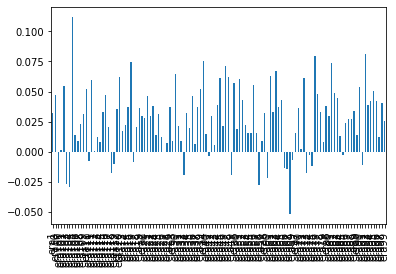

autocorrelation
-0.021344709234446913
mean correlation
0.025860724170231716
sharpe
0.922828173087683
smart sharpe
0.9386371292128654

Iteration 3:

fitting on worst eras
predicting on train


<ipython-input-4-7e0f351a00e1>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.03189434920128975
0.029753166257118154
0.009089647280626603
0.07508482606560463
0.05734842503042059
0.03250895112041689
0.0156280131818935
0.03805934949757437
0.013708487544401559
0.04719535290689926
0.05220072270778548
0.03540652260424333
0.017639615079691497
0.02235127241828902
0.037562968477934784
0.07415723758795863
-0.008194354945574927
0.02101559759118039
0.036712465175437546
0.02782353776423808
0.04640600147294927
0.02989208416553116
0.03802412702284568
0.014037237685471025
0.031182430175651865
0.012358897047050873
2.4459912623551512e-05
0.007038367106038118
0.03733849823529034
0.0642852056245886
0.021025506836028284
0.008805481522625341
-0.019569682470009637
0.032318972152163415
0.019674322802177246
0.04617953123213368
0.006584679278547713
0.03748247405437144
0.052516087052308556
0.015048594266028269
-0.003492223627249562
0.029803173966540798
0.005535139169210866
0.03907356062218465
0.061636802743573776
0.021812276763671232
0.07117266907884563
0.0618957

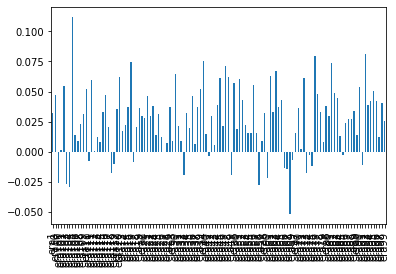

autocorrelation
-0.021344709234446913
mean correlation
0.025860724170231716
sharpe
0.922828173087683
smart sharpe
0.9386371292128654

Iteration 4:

fitting on worst eras
predicting on train


<ipython-input-4-7e0f351a00e1>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.03189434920128975
0.029753166257118154
0.009089647280626603
0.07508482606560463
0.05734842503042059
0.03250895112041689
0.0156280131818935
0.03805934949757437
0.013708487544401559
0.04719535290689926
0.05220072270778548
0.03540652260424333
0.017639615079691497
0.02235127241828902
0.037562968477934784
0.07415723758795863
-0.008194354945574927
0.02101559759118039
0.036712465175437546
0.02782353776423808
0.04640600147294927
0.02989208416553116
0.03802412702284568
0.014037237685471025
0.031182430175651865
0.012358897047050873
2.4459912623551512e-05
0.007038367106038118
0.03733849823529034
0.0642852056245886
0.021025506836028284
0.008805481522625341
-0.019569682470009637
0.032318972152163415
0.019674322802177246
0.04617953123213368
0.006584679278547713
0.03748247405437144
0.052516087052308556
0.015048594266028269
-0.003492223627249562
0.029803173966540798
0.005535139169210866
0.03907356062218465
0.061636802743573776
0.021812276763671232
0.07117266907884563
0.0618957

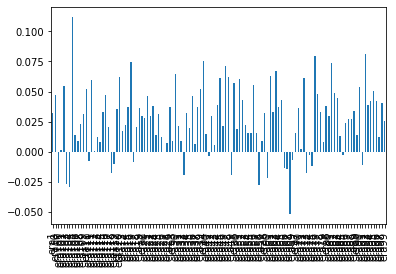

autocorrelation
-0.021344709234446913
mean correlation
0.025860724170231716
sharpe
0.922828173087683
smart sharpe
0.9386371292128654

Iteration 5:

fitting on worst eras
predicting on train


<ipython-input-4-7e0f351a00e1>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.03189434920128975
0.029753166257118154
0.009089647280626603
0.07508482606560463
0.05734842503042059
0.03250895112041689
0.0156280131818935
0.03805934949757437
0.013708487544401559
0.04719535290689926
0.05220072270778548
0.03540652260424333
0.017639615079691497
0.02235127241828902
0.037562968477934784
0.07415723758795863
-0.008194354945574927
0.02101559759118039
0.036712465175437546
0.02782353776423808
0.04640600147294927
0.02989208416553116
0.03802412702284568
0.014037237685471025
0.031182430175651865
0.012358897047050873
2.4459912623551512e-05
0.007038367106038118
0.03733849823529034
0.0642852056245886
0.021025506836028284
0.008805481522625341
-0.019569682470009637
0.032318972152163415
0.019674322802177246
0.04617953123213368
0.006584679278547713
0.03748247405437144
0.052516087052308556
0.015048594266028269
-0.003492223627249562
0.029803173966540798
0.005535139169210866
0.03907356062218465
0.061636802743573776
0.021812276763671232
0.07117266907884563
0.0618957

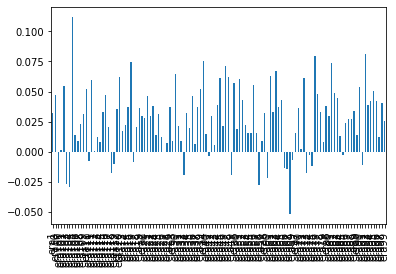

autocorrelation
-0.021344709234446913
mean correlation
0.025860724170231716
sharpe
0.922828173087683
smart sharpe
0.9386371292128654

Iteration 6:

fitting on worst eras
predicting on train


<ipython-input-4-7e0f351a00e1>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.03189434920128975
0.029753166257118154
0.009089647280626603
0.07508482606560463
0.05734842503042059
0.03250895112041689
0.0156280131818935
0.03805934949757437
0.013708487544401559
0.04719535290689926
0.05220072270778548
0.03540652260424333
0.017639615079691497
0.02235127241828902
0.037562968477934784
0.07415723758795863
-0.008194354945574927
0.02101559759118039
0.036712465175437546
0.02782353776423808
0.04640600147294927
0.02989208416553116
0.03802412702284568
0.014037237685471025
0.031182430175651865
0.012358897047050873
2.4459912623551512e-05
0.007038367106038118
0.03733849823529034
0.0642852056245886
0.021025506836028284
0.008805481522625341
-0.019569682470009637
0.032318972152163415
0.019674322802177246
0.04617953123213368
0.006584679278547713
0.03748247405437144
0.052516087052308556
0.015048594266028269
-0.003492223627249562
0.029803173966540798
0.005535139169210866
0.03907356062218465
0.061636802743573776
0.021812276763671232
0.07117266907884563
0.0618957

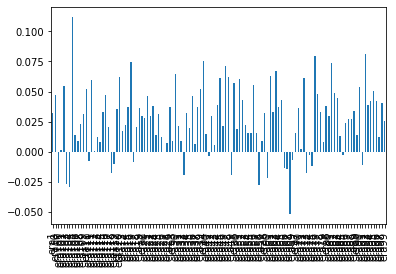

autocorrelation
-0.021344709234446913
mean correlation
0.025860724170231716
sharpe
0.922828173087683
smart sharpe
0.9386371292128654

Iteration 7:

fitting on worst eras
predicting on train


<ipython-input-4-7e0f351a00e1>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.03189434920128975
0.029753166257118154
0.009089647280626603
0.07508482606560463
0.05734842503042059
0.03250895112041689
0.0156280131818935
0.03805934949757437
0.013708487544401559
0.04719535290689926
0.05220072270778548
0.03540652260424333
0.017639615079691497
0.02235127241828902
0.037562968477934784
0.07415723758795863
-0.008194354945574927
0.02101559759118039
0.036712465175437546
0.02782353776423808
0.04640600147294927
0.02989208416553116
0.03802412702284568
0.014037237685471025
0.031182430175651865
0.012358897047050873
2.4459912623551512e-05
0.007038367106038118
0.03733849823529034
0.0642852056245886
0.021025506836028284
0.008805481522625341
-0.019569682470009637
0.032318972152163415
0.019674322802177246
0.04617953123213368
0.006584679278547713
0.03748247405437144
0.052516087052308556
0.015048594266028269
-0.003492223627249562
0.029803173966540798
0.005535139169210866
0.03907356062218465
0.061636802743573776
0.021812276763671232
0.07117266907884563
0.0618957

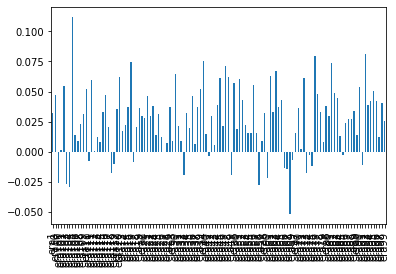

autocorrelation
-0.021344709234446913
mean correlation
0.025860724170231716
sharpe
0.922828173087683
smart sharpe
0.9386371292128654

Iteration 8:

fitting on worst eras
predicting on train


<ipython-input-4-7e0f351a00e1>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.03189434920128975
0.029753166257118154
0.009089647280626603
0.07508482606560463
0.05734842503042059
0.03250895112041689
0.0156280131818935
0.03805934949757437
0.013708487544401559
0.04719535290689926
0.05220072270778548
0.03540652260424333
0.017639615079691497
0.02235127241828902
0.037562968477934784
0.07415723758795863
-0.008194354945574927
0.02101559759118039
0.036712465175437546
0.02782353776423808
0.04640600147294927
0.02989208416553116
0.03802412702284568
0.014037237685471025
0.031182430175651865
0.012358897047050873
2.4459912623551512e-05
0.007038367106038118
0.03733849823529034
0.0642852056245886
0.021025506836028284
0.008805481522625341
-0.019569682470009637
0.032318972152163415
0.019674322802177246
0.04617953123213368
0.006584679278547713
0.03748247405437144
0.052516087052308556
0.015048594266028269
-0.003492223627249562
0.029803173966540798
0.005535139169210866
0.03907356062218465
0.061636802743573776
0.021812276763671232
0.07117266907884563
0.0618957

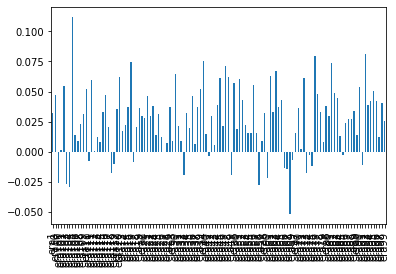

autocorrelation
-0.021344709234446913
mean correlation
0.025860724170231716
sharpe
0.922828173087683
smart sharpe
0.9386371292128654

Iteration 9:

fitting on worst eras
predicting on train


<ipython-input-4-7e0f351a00e1>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.03189434920128975
0.029753166257118154
0.009089647280626603
0.07508482606560463
0.05734842503042059
0.03250895112041689
0.0156280131818935
0.03805934949757437
0.013708487544401559
0.04719535290689926
0.05220072270778548
0.03540652260424333
0.017639615079691497
0.02235127241828902
0.037562968477934784
0.07415723758795863
-0.008194354945574927
0.02101559759118039
0.036712465175437546
0.02782353776423808
0.04640600147294927
0.02989208416553116
0.03802412702284568
0.014037237685471025
0.031182430175651865
0.012358897047050873
2.4459912623551512e-05
0.007038367106038118
0.03733849823529034
0.0642852056245886
0.021025506836028284
0.008805481522625341
-0.019569682470009637
0.032318972152163415
0.019674322802177246
0.04617953123213368
0.006584679278547713
0.03748247405437144
0.052516087052308556
0.015048594266028269
-0.003492223627249562
0.029803173966540798
0.005535139169210866
0.03907356062218465
0.061636802743573776
0.021812276763671232
0.07117266907884563
0.0618957

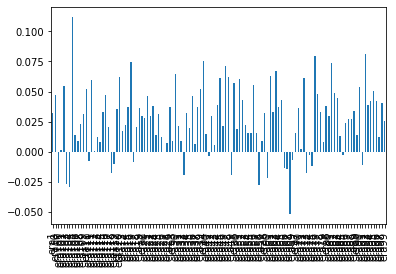

autocorrelation
-0.021344709234446913
mean correlation
0.025860724170231716
sharpe
0.922828173087683
smart sharpe
0.9386371292128654

Iteration 10:

fitting on worst eras
predicting on train


<ipython-input-4-7e0f351a00e1>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.03189434920128975
0.029753166257118154
0.009089647280626603
0.07508482606560463
0.05734842503042059
0.03250895112041689
0.0156280131818935
0.03805934949757437
0.013708487544401559
0.04719535290689926
0.05220072270778548
0.03540652260424333
0.017639615079691497
0.02235127241828902
0.037562968477934784
0.07415723758795863
-0.008194354945574927
0.02101559759118039
0.036712465175437546
0.02782353776423808
0.04640600147294927
0.02989208416553116
0.03802412702284568
0.014037237685471025
0.031182430175651865
0.012358897047050873
2.4459912623551512e-05
0.007038367106038118
0.03733849823529034
0.0642852056245886
0.021025506836028284
0.008805481522625341
-0.019569682470009637
0.032318972152163415
0.019674322802177246
0.04617953123213368
0.006584679278547713
0.03748247405437144
0.052516087052308556
0.015048594266028269
-0.003492223627249562
0.029803173966540798
0.005535139169210866
0.03907356062218465
0.061636802743573776
0.021812276763671232
0.07117266907884563
0.0618957

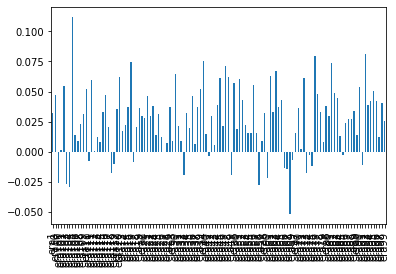

autocorrelation
-0.021344709234446913
mean correlation
0.025860724170231716
sharpe
0.922828173087683
smart sharpe
0.9386371292128654

Iteration 11:

fitting on worst eras
predicting on train


<ipython-input-4-7e0f351a00e1>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.03189434920128975
0.029753166257118154
0.009089647280626603
0.07508482606560463
0.05734842503042059
0.03250895112041689
0.0156280131818935
0.03805934949757437
0.013708487544401559
0.04719535290689926
0.05220072270778548
0.03540652260424333
0.017639615079691497
0.02235127241828902
0.037562968477934784
0.07415723758795863
-0.008194354945574927
0.02101559759118039
0.036712465175437546
0.02782353776423808
0.04640600147294927
0.02989208416553116
0.03802412702284568
0.014037237685471025
0.031182430175651865
0.012358897047050873
2.4459912623551512e-05
0.007038367106038118
0.03733849823529034
0.0642852056245886
0.021025506836028284
0.008805481522625341
-0.019569682470009637
0.032318972152163415
0.019674322802177246
0.04617953123213368
0.006584679278547713
0.03748247405437144
0.052516087052308556
0.015048594266028269
-0.003492223627249562
0.029803173966540798
0.005535139169210866
0.03907356062218465
0.061636802743573776
0.021812276763671232
0.07117266907884563
0.0618957

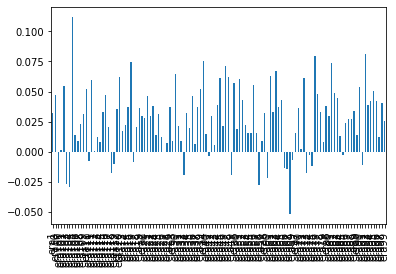

autocorrelation
-0.021344709234446913
mean correlation
0.025860724170231716
sharpe
0.922828173087683
smart sharpe
0.9386371292128654

Iteration 12:

fitting on worst eras
predicting on train


<ipython-input-4-7e0f351a00e1>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.03189434920128975
0.029753166257118154
0.009089647280626603
0.07508482606560463
0.05734842503042059
0.03250895112041689
0.0156280131818935
0.03805934949757437
0.013708487544401559
0.04719535290689926
0.05220072270778548
0.03540652260424333
0.017639615079691497
0.02235127241828902
0.037562968477934784
0.07415723758795863
-0.008194354945574927
0.02101559759118039
0.036712465175437546
0.02782353776423808
0.04640600147294927
0.02989208416553116
0.03802412702284568
0.014037237685471025
0.031182430175651865
0.012358897047050873
2.4459912623551512e-05
0.007038367106038118
0.03733849823529034
0.0642852056245886
0.021025506836028284
0.008805481522625341
-0.019569682470009637
0.032318972152163415
0.019674322802177246
0.04617953123213368
0.006584679278547713
0.03748247405437144
0.052516087052308556
0.015048594266028269
-0.003492223627249562
0.029803173966540798
0.005535139169210866
0.03907356062218465
0.061636802743573776
0.021812276763671232
0.07117266907884563
0.0618957

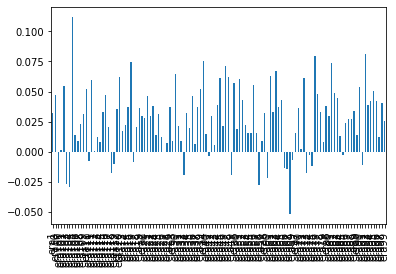

autocorrelation
-0.021344709234446913
mean correlation
0.025860724170231716
sharpe
0.922828173087683
smart sharpe
0.9386371292128654

Iteration 13:

fitting on worst eras
predicting on train


<ipython-input-4-7e0f351a00e1>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.03189434920128975
0.029753166257118154
0.009089647280626603
0.07508482606560463
0.05734842503042059
0.03250895112041689
0.0156280131818935
0.03805934949757437
0.013708487544401559
0.04719535290689926
0.05220072270778548
0.03540652260424333
0.017639615079691497
0.02235127241828902
0.037562968477934784
0.07415723758795863
-0.008194354945574927
0.02101559759118039
0.036712465175437546
0.02782353776423808
0.04640600147294927
0.02989208416553116
0.03802412702284568
0.014037237685471025
0.031182430175651865
0.012358897047050873
2.4459912623551512e-05
0.007038367106038118
0.03733849823529034
0.0642852056245886
0.021025506836028284
0.008805481522625341
-0.019569682470009637
0.032318972152163415
0.019674322802177246
0.04617953123213368
0.006584679278547713
0.03748247405437144
0.052516087052308556
0.015048594266028269
-0.003492223627249562
0.029803173966540798
0.005535139169210866
0.03907356062218465
0.061636802743573776
0.021812276763671232
0.07117266907884563
0.0618957

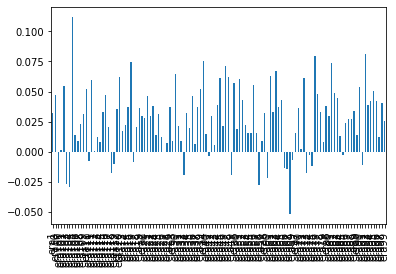

autocorrelation
-0.021344709234446913
mean correlation
0.025860724170231716
sharpe
0.922828173087683
smart sharpe
0.9386371292128654

Iteration 14:

fitting on worst eras
predicting on train


<ipython-input-4-7e0f351a00e1>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.03189434920128975
0.029753166257118154
0.009089647280626603
0.07508482606560463
0.05734842503042059
0.03250895112041689
0.0156280131818935
0.03805934949757437
0.013708487544401559
0.04719535290689926
0.05220072270778548
0.03540652260424333
0.017639615079691497
0.02235127241828902
0.037562968477934784
0.07415723758795863
-0.008194354945574927
0.02101559759118039
0.036712465175437546
0.02782353776423808
0.04640600147294927
0.02989208416553116
0.03802412702284568
0.014037237685471025
0.031182430175651865
0.012358897047050873
2.4459912623551512e-05
0.007038367106038118
0.03733849823529034
0.0642852056245886
0.021025506836028284
0.008805481522625341
-0.019569682470009637
0.032318972152163415
0.019674322802177246
0.04617953123213368
0.006584679278547713
0.03748247405437144
0.052516087052308556
0.015048594266028269
-0.003492223627249562
0.029803173966540798
0.005535139169210866
0.03907356062218465
0.061636802743573776
0.021812276763671232
0.07117266907884563
0.0618957

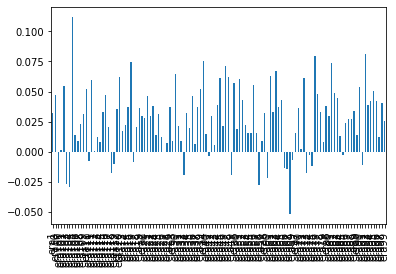

autocorrelation
-0.021344709234446913
mean correlation
0.025860724170231716
sharpe
0.922828173087683
smart sharpe
0.9386371292128654

Iteration 15:

fitting on worst eras
predicting on train


<ipython-input-4-7e0f351a00e1>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.03189434920128975
0.029753166257118154
0.009089647280626603
0.07508482606560463
0.05734842503042059
0.03250895112041689
0.0156280131818935
0.03805934949757437
0.013708487544401559
0.04719535290689926
0.05220072270778548
0.03540652260424333
0.017639615079691497
0.02235127241828902
0.037562968477934784
0.07415723758795863
-0.008194354945574927
0.02101559759118039
0.036712465175437546
0.02782353776423808
0.04640600147294927
0.02989208416553116
0.03802412702284568
0.014037237685471025
0.031182430175651865
0.012358897047050873
2.4459912623551512e-05
0.007038367106038118
0.03733849823529034
0.0642852056245886
0.021025506836028284
0.008805481522625341
-0.019569682470009637
0.032318972152163415
0.019674322802177246
0.04617953123213368
0.006584679278547713
0.03748247405437144
0.052516087052308556
0.015048594266028269
-0.003492223627249562
0.029803173966540798
0.005535139169210866
0.03907356062218465
0.061636802743573776
0.021812276763671232
0.07117266907884563
0.0618957

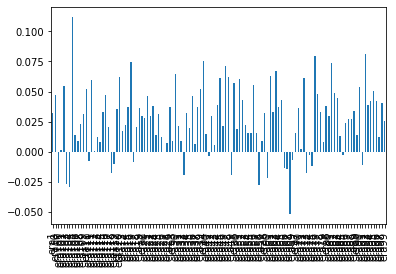

autocorrelation
-0.021344709234446913
mean correlation
0.025860724170231716
sharpe
0.922828173087683
smart sharpe
0.9386371292128654

Iteration 16:

fitting on worst eras
predicting on train


<ipython-input-4-7e0f351a00e1>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.03189434920128975
0.029753166257118154
0.009089647280626603
0.07508482606560463
0.05734842503042059
0.03250895112041689
0.0156280131818935
0.03805934949757437
0.013708487544401559
0.04719535290689926
0.05220072270778548
0.03540652260424333
0.017639615079691497
0.02235127241828902
0.037562968477934784
0.07415723758795863
-0.008194354945574927
0.02101559759118039
0.036712465175437546
0.02782353776423808
0.04640600147294927
0.02989208416553116
0.03802412702284568
0.014037237685471025
0.031182430175651865
0.012358897047050873
2.4459912623551512e-05
0.007038367106038118
0.03733849823529034
0.0642852056245886
0.021025506836028284
0.008805481522625341
-0.019569682470009637
0.032318972152163415
0.019674322802177246
0.04617953123213368
0.006584679278547713
0.03748247405437144
0.052516087052308556
0.015048594266028269
-0.003492223627249562
0.029803173966540798
0.005535139169210866
0.03907356062218465
0.061636802743573776
0.021812276763671232
0.07117266907884563
0.0618957

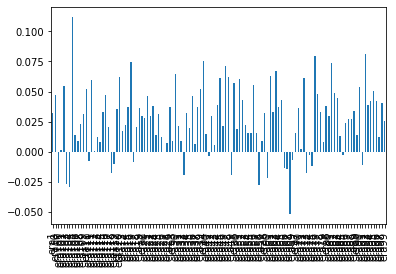

autocorrelation
-0.021344709234446913
mean correlation
0.025860724170231716
sharpe
0.922828173087683
smart sharpe
0.9386371292128654

Iteration 17:

fitting on worst eras
predicting on train


<ipython-input-4-7e0f351a00e1>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.03189434920128975
0.029753166257118154
0.009089647280626603
0.07508482606560463
0.05734842503042059
0.03250895112041689
0.0156280131818935
0.03805934949757437
0.013708487544401559
0.04719535290689926
0.05220072270778548
0.03540652260424333
0.017639615079691497
0.02235127241828902
0.037562968477934784
0.07415723758795863
-0.008194354945574927
0.02101559759118039
0.036712465175437546
0.02782353776423808
0.04640600147294927
0.02989208416553116
0.03802412702284568
0.014037237685471025
0.031182430175651865
0.012358897047050873
2.4459912623551512e-05
0.007038367106038118
0.03733849823529034
0.0642852056245886
0.021025506836028284
0.008805481522625341
-0.019569682470009637
0.032318972152163415
0.019674322802177246
0.04617953123213368
0.006584679278547713
0.03748247405437144
0.052516087052308556
0.015048594266028269
-0.003492223627249562
0.029803173966540798
0.005535139169210866
0.03907356062218465
0.061636802743573776
0.021812276763671232
0.07117266907884563
0.0618957

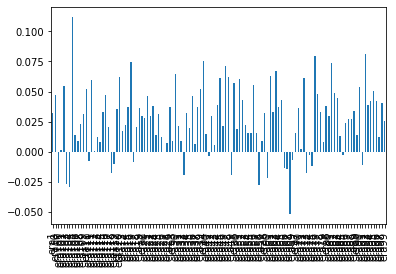

autocorrelation
-0.021344709234446913
mean correlation
0.025860724170231716
sharpe
0.922828173087683
smart sharpe
0.9386371292128654

Iteration 18:

fitting on worst eras
predicting on train


<ipython-input-4-7e0f351a00e1>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.03189434920128975
0.029753166257118154
0.009089647280626603
0.07508482606560463
0.05734842503042059
0.03250895112041689
0.0156280131818935
0.03805934949757437
0.013708487544401559
0.04719535290689926
0.05220072270778548
0.03540652260424333
0.017639615079691497
0.02235127241828902
0.037562968477934784
0.07415723758795863
-0.008194354945574927
0.02101559759118039
0.036712465175437546
0.02782353776423808
0.04640600147294927
0.02989208416553116
0.03802412702284568
0.014037237685471025
0.031182430175651865
0.012358897047050873
2.4459912623551512e-05
0.007038367106038118
0.03733849823529034
0.0642852056245886
0.021025506836028284
0.008805481522625341
-0.019569682470009637
0.032318972152163415
0.019674322802177246
0.04617953123213368
0.006584679278547713
0.03748247405437144
0.052516087052308556
0.015048594266028269
-0.003492223627249562
0.029803173966540798
0.005535139169210866
0.03907356062218465
0.061636802743573776
0.021812276763671232
0.07117266907884563
0.0618957

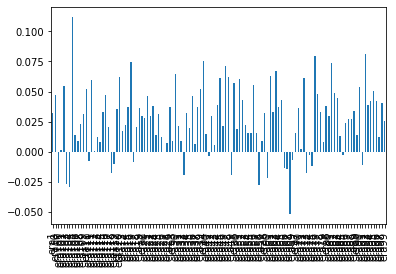

autocorrelation
-0.021344709234446913
mean correlation
0.025860724170231716
sharpe
0.922828173087683
smart sharpe
0.9386371292128654

Iteration 19:

fitting on worst eras
predicting on train


<ipython-input-4-7e0f351a00e1>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.03189434920128975
0.029753166257118154
0.009089647280626603
0.07508482606560463
0.05734842503042059
0.03250895112041689
0.0156280131818935
0.03805934949757437
0.013708487544401559
0.04719535290689926
0.05220072270778548
0.03540652260424333
0.017639615079691497
0.02235127241828902
0.037562968477934784
0.07415723758795863
-0.008194354945574927
0.02101559759118039
0.036712465175437546
0.02782353776423808
0.04640600147294927
0.02989208416553116
0.03802412702284568
0.014037237685471025
0.031182430175651865
0.012358897047050873
2.4459912623551512e-05
0.007038367106038118
0.03733849823529034
0.0642852056245886
0.021025506836028284
0.008805481522625341
-0.019569682470009637
0.032318972152163415
0.019674322802177246
0.04617953123213368
0.006584679278547713
0.03748247405437144
0.052516087052308556
0.015048594266028269
-0.003492223627249562
0.029803173966540798
0.005535139169210866
0.03907356062218465
0.061636802743573776
0.021812276763671232
0.07117266907884563
0.0618957

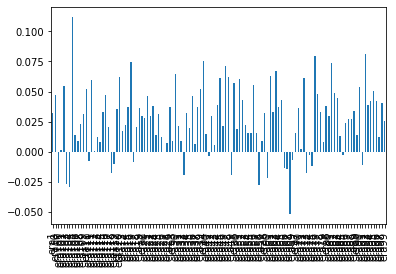

autocorrelation
-0.021344709234446913
mean correlation
0.025860724170231716
sharpe
0.922828173087683
smart sharpe
0.9386371292128654

Iteration 20:

fitting on worst eras
predicting on train


<ipython-input-4-7e0f351a00e1>:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
0.03189434920128975
0.029753166257118154
0.009089647280626603
0.07508482606560463
0.05734842503042059
0.03250895112041689
0.0156280131818935
0.03805934949757437
0.013708487544401559
0.04719535290689926
0.05220072270778548
0.03540652260424333
0.017639615079691497
0.02235127241828902
0.037562968477934784
0.07415723758795863
-0.008194354945574927
0.02101559759118039
0.036712465175437546
0.02782353776423808
0.04640600147294927
0.02989208416553116
0.03802412702284568
0.014037237685471025
0.031182430175651865
0.012358897047050873
2.4459912623551512e-05
0.007038367106038118
0.03733849823529034
0.0642852056245886
0.021025506836028284
0.008805481522625341
-0.019569682470009637
0.032318972152163415
0.019674322802177246
0.04617953123213368
0.006584679278547713
0.03748247405437144
0.052516087052308556
0.015048594266028269
-0.003492223627249562
0.029803173966540798
0.005535139169210866
0.03907356062218465
0.061636802743573776
0.021812276763671232
0.07117266907884563
0.0618957

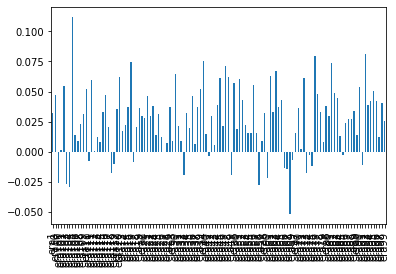

autocorrelation
-0.021344709234446913
mean correlation
0.025860724170231716
sharpe
0.922828173087683
smart sharpe
0.9386371292128654


In [9]:
boost_model = era_boost_train(X_train, y_train,
                              era_col=pca_train["era"], proportion=0.5,
                              trees_per_step=10, num_iters=20, test_model=boost_model)

In [ ]:
tournament_calc = tournament_static.copy()
X_tournament, y_tournament = clean_for_xgboost(pca_tournament)
# dtournament = xgboost.DMatrix(X_tournament, y_tournament)
tournament_calc.loc[:,"prediction"] = boost_model.predict(X_tournament)
tournament_calc.set_index('id', inplace=True)
tournament_calc['prediction'].to_csv(f"era_boost_submission1.csv", header=True)

In [11]:
def train_model(train, model=None):
    X, y = clean_for_xgboost(train)
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    dtrain = xgboost.DMatrix(X_train, y_train)
    dtest = xgboost.DMatrix(X_test, y_test)
    
#     dtrain, dtest = setup_xgboost_training(train)
    param = {
        'colsample_bytree': 0.7334,
        'gamma': 1.412,
        'max_depth': 10,
        'min_child_weight': 18.26,
        'subsample': 1.0,
        'eta': 0.05,
        'objective': 'reg:squarederror',
        'eval_metric':'rmse',
        'verbosity': 0
    }
    evals_result = {}
    
    if model is not None:
        tmodel = xgboost.train(
            params=param,
            dtrain=dtrain,
            feval=correlation_score,
            num_boost_round=1000,
            evals=[(dtrain, 'train'), (dtest, 'test')],
            evals_result=evals_result,
            xgb_model=model,
            verbose_eval=10,
        )
    else:
        tmodel = xgboost.train(
            params=param,
            dtrain=dtrain,
            feval=correlation_score,
            num_boost_round=1000,
            evals=[(dtrain, 'train'), (dtest, 'test')],
            evals_result=evals_result,
            verbose_eval=10,
        )

    hex_gen = uuid.uuid4()
    print(f"Hex number associated with this is {hex_gen}")
    save_model(model, f'model_{hex_gen}.pickle.dat')
    return tmodel

In [12]:
model = train_model(pca_train)

[1]	train-rmse:0.22312	train-pos_corr:0.05228	test-rmse:0.22369	test-pos_corr:0.01460
[2]	train-rmse:0.22311	train-pos_corr:0.05529	test-rmse:0.22369	test-pos_corr:0.01716
[3]	train-rmse:0.22309	train-pos_corr:0.06006	test-rmse:0.22368	test-pos_corr:0.01749
[4]	train-rmse:0.22308	train-pos_corr:0.06094	test-rmse:0.22368	test-pos_corr:0.01886
[5]	train-rmse:0.22306	train-pos_corr:0.06674	test-rmse:0.22367	test-pos_corr:0.02202
[6]	train-rmse:0.22305	train-pos_corr:0.06629	test-rmse:0.22367	test-pos_corr:0.02199
[7]	train-rmse:0.22304	train-pos_corr:0.06786	test-rmse:0.22367	test-pos_corr:0.02204
[8]	train-rmse:0.22302	train-pos_corr:0.07457	test-rmse:0.22367	test-pos_corr:0.02134
[9]	train-rmse:0.22301	train-pos_corr:0.07397	test-rmse:0.22366	test-pos_corr:0.02154
[11]	train-rmse:0.22299	train-pos_corr:0.07339	test-rmse:0.22365	test-pos_corr:0.02321
[12]	train-rmse:0.22298	train-pos_corr:0.07643	test-rmse:0.22365	test-pos_corr:0.02379
[13]	train-rmse:0.22296	train-pos_corr:0.07790	test-

[106]	train-rmse:0.22245	train-pos_corr:0.13175	test-rmse:0.22359	test-pos_corr:0.03179
[107]	train-rmse:0.22244	train-pos_corr:0.13242	test-rmse:0.22359	test-pos_corr:0.03144
[108]	train-rmse:0.22243	train-pos_corr:0.13331	test-rmse:0.22359	test-pos_corr:0.03148
[109]	train-rmse:0.22243	train-pos_corr:0.13331	test-rmse:0.22359	test-pos_corr:0.03148
[111]	train-rmse:0.22243	train-pos_corr:0.13331	test-rmse:0.22359	test-pos_corr:0.03148
[112]	train-rmse:0.22243	train-pos_corr:0.13331	test-rmse:0.22359	test-pos_corr:0.03148
[113]	train-rmse:0.22243	train-pos_corr:0.13331	test-rmse:0.22359	test-pos_corr:0.03148
[114]	train-rmse:0.22242	train-pos_corr:0.13439	test-rmse:0.22359	test-pos_corr:0.03145
[115]	train-rmse:0.22242	train-pos_corr:0.13499	test-rmse:0.22359	test-pos_corr:0.03140
[116]	train-rmse:0.22242	train-pos_corr:0.13499	test-rmse:0.22359	test-pos_corr:0.03140
[117]	train-rmse:0.22241	train-pos_corr:0.13574	test-rmse:0.22359	test-pos_corr:0.03134
[118]	train-rmse:0.22241	train-p

[211]	train-rmse:0.22211	train-pos_corr:0.15934	test-rmse:0.22358	test-pos_corr:0.03300
[212]	train-rmse:0.22210	train-pos_corr:0.16009	test-rmse:0.22358	test-pos_corr:0.03270
[213]	train-rmse:0.22210	train-pos_corr:0.16052	test-rmse:0.22358	test-pos_corr:0.03274
[214]	train-rmse:0.22210	train-pos_corr:0.16052	test-rmse:0.22358	test-pos_corr:0.03274
[215]	train-rmse:0.22210	train-pos_corr:0.16052	test-rmse:0.22358	test-pos_corr:0.03274
[216]	train-rmse:0.22210	train-pos_corr:0.16052	test-rmse:0.22358	test-pos_corr:0.03274
[217]	train-rmse:0.22210	train-pos_corr:0.16052	test-rmse:0.22358	test-pos_corr:0.03274
[218]	train-rmse:0.22209	train-pos_corr:0.16085	test-rmse:0.22358	test-pos_corr:0.03291
[219]	train-rmse:0.22209	train-pos_corr:0.16085	test-rmse:0.22358	test-pos_corr:0.03291
[221]	train-rmse:0.22209	train-pos_corr:0.16085	test-rmse:0.22358	test-pos_corr:0.03291
[222]	train-rmse:0.22209	train-pos_corr:0.16110	test-rmse:0.22358	test-pos_corr:0.03313
[223]	train-rmse:0.22208	train-p

[315]	train-rmse:0.22196	train-pos_corr:0.16978	test-rmse:0.22357	test-pos_corr:0.03349
[316]	train-rmse:0.22196	train-pos_corr:0.16978	test-rmse:0.22357	test-pos_corr:0.03349
[317]	train-rmse:0.22196	train-pos_corr:0.17005	test-rmse:0.22357	test-pos_corr:0.03362
[318]	train-rmse:0.22195	train-pos_corr:0.17030	test-rmse:0.22357	test-pos_corr:0.03373
[319]	train-rmse:0.22195	train-pos_corr:0.17030	test-rmse:0.22357	test-pos_corr:0.03373
[321]	train-rmse:0.22195	train-pos_corr:0.17013	test-rmse:0.22357	test-pos_corr:0.03374
[322]	train-rmse:0.22195	train-pos_corr:0.17013	test-rmse:0.22357	test-pos_corr:0.03374
[323]	train-rmse:0.22195	train-pos_corr:0.17013	test-rmse:0.22357	test-pos_corr:0.03374
[324]	train-rmse:0.22194	train-pos_corr:0.17041	test-rmse:0.22357	test-pos_corr:0.03385
[325]	train-rmse:0.22194	train-pos_corr:0.17041	test-rmse:0.22357	test-pos_corr:0.03385
[326]	train-rmse:0.22194	train-pos_corr:0.17081	test-rmse:0.22357	test-pos_corr:0.03398
[327]	train-rmse:0.22194	train-p

[419]	train-rmse:0.22183	train-pos_corr:0.17749	test-rmse:0.22357	test-pos_corr:0.03352
[421]	train-rmse:0.22183	train-pos_corr:0.17749	test-rmse:0.22357	test-pos_corr:0.03352
[422]	train-rmse:0.22183	train-pos_corr:0.17749	test-rmse:0.22357	test-pos_corr:0.03352
[423]	train-rmse:0.22183	train-pos_corr:0.17781	test-rmse:0.22358	test-pos_corr:0.03336
[424]	train-rmse:0.22183	train-pos_corr:0.17781	test-rmse:0.22358	test-pos_corr:0.03336
[425]	train-rmse:0.22183	train-pos_corr:0.17781	test-rmse:0.22358	test-pos_corr:0.03336
[426]	train-rmse:0.22182	train-pos_corr:0.17827	test-rmse:0.22357	test-pos_corr:0.03349
[427]	train-rmse:0.22182	train-pos_corr:0.17827	test-rmse:0.22357	test-pos_corr:0.03349
[428]	train-rmse:0.22182	train-pos_corr:0.17827	test-rmse:0.22357	test-pos_corr:0.03349
[429]	train-rmse:0.22182	train-pos_corr:0.17832	test-rmse:0.22357	test-pos_corr:0.03344
[431]	train-rmse:0.22182	train-pos_corr:0.17832	test-rmse:0.22357	test-pos_corr:0.03344
[432]	train-rmse:0.22182	train-p

[524]	train-rmse:0.22174	train-pos_corr:0.18338	test-rmse:0.22358	test-pos_corr:0.03306
[525]	train-rmse:0.22174	train-pos_corr:0.18338	test-rmse:0.22358	test-pos_corr:0.03306
[526]	train-rmse:0.22173	train-pos_corr:0.18399	test-rmse:0.22358	test-pos_corr:0.03306
[527]	train-rmse:0.22173	train-pos_corr:0.18421	test-rmse:0.22358	test-pos_corr:0.03301
[528]	train-rmse:0.22173	train-pos_corr:0.18421	test-rmse:0.22358	test-pos_corr:0.03301
[529]	train-rmse:0.22173	train-pos_corr:0.18432	test-rmse:0.22358	test-pos_corr:0.03311
[531]	train-rmse:0.22172	train-pos_corr:0.18456	test-rmse:0.22358	test-pos_corr:0.03316
[532]	train-rmse:0.22172	train-pos_corr:0.18456	test-rmse:0.22358	test-pos_corr:0.03316
[533]	train-rmse:0.22172	train-pos_corr:0.18456	test-rmse:0.22358	test-pos_corr:0.03316
[534]	train-rmse:0.22172	train-pos_corr:0.18456	test-rmse:0.22358	test-pos_corr:0.03316
[535]	train-rmse:0.22172	train-pos_corr:0.18456	test-rmse:0.22358	test-pos_corr:0.03316
[536]	train-rmse:0.22172	train-p

[628]	train-rmse:0.22167	train-pos_corr:0.18743	test-rmse:0.22358	test-pos_corr:0.03300
[629]	train-rmse:0.22167	train-pos_corr:0.18743	test-rmse:0.22358	test-pos_corr:0.03300
[631]	train-rmse:0.22167	train-pos_corr:0.18743	test-rmse:0.22358	test-pos_corr:0.03300
[632]	train-rmse:0.22167	train-pos_corr:0.18743	test-rmse:0.22358	test-pos_corr:0.03300
[633]	train-rmse:0.22167	train-pos_corr:0.18743	test-rmse:0.22358	test-pos_corr:0.03300
[634]	train-rmse:0.22167	train-pos_corr:0.18743	test-rmse:0.22358	test-pos_corr:0.03300
[635]	train-rmse:0.22167	train-pos_corr:0.18743	test-rmse:0.22358	test-pos_corr:0.03300
[636]	train-rmse:0.22167	train-pos_corr:0.18743	test-rmse:0.22358	test-pos_corr:0.03300
[637]	train-rmse:0.22167	train-pos_corr:0.18743	test-rmse:0.22358	test-pos_corr:0.03300
[638]	train-rmse:0.22167	train-pos_corr:0.18743	test-rmse:0.22358	test-pos_corr:0.03300
[639]	train-rmse:0.22167	train-pos_corr:0.18765	test-rmse:0.22358	test-pos_corr:0.03307
[641]	train-rmse:0.22167	train-p

[733]	train-rmse:0.22157	train-pos_corr:0.19348	test-rmse:0.22358	test-pos_corr:0.03286
[734]	train-rmse:0.22157	train-pos_corr:0.19348	test-rmse:0.22358	test-pos_corr:0.03286
[735]	train-rmse:0.22157	train-pos_corr:0.19348	test-rmse:0.22358	test-pos_corr:0.03286
[736]	train-rmse:0.22157	train-pos_corr:0.19382	test-rmse:0.22359	test-pos_corr:0.03259
[737]	train-rmse:0.22156	train-pos_corr:0.19392	test-rmse:0.22359	test-pos_corr:0.03250
[738]	train-rmse:0.22156	train-pos_corr:0.19392	test-rmse:0.22359	test-pos_corr:0.03250
[739]	train-rmse:0.22156	train-pos_corr:0.19392	test-rmse:0.22359	test-pos_corr:0.03250
[741]	train-rmse:0.22156	train-pos_corr:0.19418	test-rmse:0.22359	test-pos_corr:0.03261
[742]	train-rmse:0.22156	train-pos_corr:0.19418	test-rmse:0.22359	test-pos_corr:0.03261
[743]	train-rmse:0.22156	train-pos_corr:0.19418	test-rmse:0.22359	test-pos_corr:0.03261
[744]	train-rmse:0.22156	train-pos_corr:0.19418	test-rmse:0.22359	test-pos_corr:0.03261
[745]	train-rmse:0.22156	train-p

[837]	train-rmse:0.22148	train-pos_corr:0.19872	test-rmse:0.22359	test-pos_corr:0.03293
[838]	train-rmse:0.22148	train-pos_corr:0.19872	test-rmse:0.22359	test-pos_corr:0.03293
[839]	train-rmse:0.22148	train-pos_corr:0.19872	test-rmse:0.22359	test-pos_corr:0.03293
[841]	train-rmse:0.22148	train-pos_corr:0.19872	test-rmse:0.22359	test-pos_corr:0.03293
[842]	train-rmse:0.22148	train-pos_corr:0.19872	test-rmse:0.22359	test-pos_corr:0.03293
[843]	train-rmse:0.22148	train-pos_corr:0.19872	test-rmse:0.22359	test-pos_corr:0.03293
[844]	train-rmse:0.22148	train-pos_corr:0.19872	test-rmse:0.22359	test-pos_corr:0.03293
[845]	train-rmse:0.22148	train-pos_corr:0.19872	test-rmse:0.22359	test-pos_corr:0.03293
[846]	train-rmse:0.22148	train-pos_corr:0.19872	test-rmse:0.22359	test-pos_corr:0.03293
[847]	train-rmse:0.22148	train-pos_corr:0.19872	test-rmse:0.22359	test-pos_corr:0.03293
[848]	train-rmse:0.22148	train-pos_corr:0.19872	test-rmse:0.22359	test-pos_corr:0.03293
[849]	train-rmse:0.22148	train-p

[942]	train-rmse:0.22147	train-pos_corr:0.19918	test-rmse:0.22359	test-pos_corr:0.03296
[943]	train-rmse:0.22147	train-pos_corr:0.19918	test-rmse:0.22359	test-pos_corr:0.03296
[944]	train-rmse:0.22147	train-pos_corr:0.19918	test-rmse:0.22359	test-pos_corr:0.03296
[945]	train-rmse:0.22147	train-pos_corr:0.19918	test-rmse:0.22359	test-pos_corr:0.03296
[946]	train-rmse:0.22147	train-pos_corr:0.19918	test-rmse:0.22359	test-pos_corr:0.03296
[947]	train-rmse:0.22147	train-pos_corr:0.19918	test-rmse:0.22359	test-pos_corr:0.03296
[948]	train-rmse:0.22147	train-pos_corr:0.19918	test-rmse:0.22359	test-pos_corr:0.03296
[949]	train-rmse:0.22147	train-pos_corr:0.19918	test-rmse:0.22359	test-pos_corr:0.03296
[951]	train-rmse:0.22147	train-pos_corr:0.19918	test-rmse:0.22359	test-pos_corr:0.03296
[952]	train-rmse:0.22147	train-pos_corr:0.19918	test-rmse:0.22359	test-pos_corr:0.03296
[953]	train-rmse:0.22147	train-pos_corr:0.19918	test-rmse:0.22359	test-pos_corr:0.03296
[954]	train-rmse:0.22147	train-p

In [13]:
save_model(model, 'model2.pkl')

In [107]:
submissions = []
X_tournament, y_tournament = clean_for_xgboost(pca_tournament)
dtournament = xgboost.DMatrix(X_tournament, y_tournament)
# model_name = 'boomkin'
# model_id = '6bd2c44b-38bb-4918-9f08-cc1e880bc6a5'
# model = load_model(f'models/{model_name}/model_{model_id}.pickle.dat')
pca_tournament.loc[:,"prediction"] = model.predict(dtournament)
submissions.append(pca_tournament)
generate_submission(pca_tournament, name=f'model_{model_name}_submission.csv')

In [33]:
def neutralize(series, by, proportion):
    scores = series.values.reshape(-1, 1)
    exposures = by.values.reshape(-1, 1)
    exposures = np.hstack((exposures, np.array([np.mean(series)] * len(exposures)).reshape(-1, 1)))
    correction = proportion * (exposures.dot(np.linalg.lstsq(exposures, scores)[0]))
    corrected_scores = scores - correction
    neutralized = pd.Series(corrected_scores.ravel(), index=series.index)
    return neutralized

by = pd.read_csv('data/numerai_dataset_'+str(NAPI.get_current_round())+'/example_predictions.csv')
neut = pd.DataFrame({'prediction': neutralize(pca_tournament['prediction'], by['prediction'], 0.3)})

conc = pd.concat([by.drop(columns="prediction"),neut], axis=1)
conc.to_csv("neutralized_model_boomkin_submission.csv", index=False) # submission file

<ipython-input-33-e06180fd2d06>:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  correction = proportion * (exposures.dot(np.linalg.lstsq(exposures, scores)[0]))


In [42]:
sum(n < 0 for n in conc.prediction.values.flatten())
num = conc._get_numeric_data()
num[num < 0] = 0

0

In [53]:
def correlation_score(preds, dtrain):
    return "corr", np.corrcoef(preds, dtrain.get_label())[0,1]

In [ ]:
X_tournament, y_tournament = clean_for_xgboost(pca_tournament)
dtournament = xgboost.DMatrix(X_tournament, y_tournament)

In [101]:
def train_test_dataframe(df):
    msk = np.random.rand(len(df)) < 0.8
    train = df[msk]
    test = df[~msk]
    return train, test

In [109]:
grouped = pca_train.groupby('era')
for name, group in grouped:
    train, test = train_test_dataframe(group)
    print("Current era", name)
    model = None
    model = train_model(train, test, model)

Current era era1
[1]	train-logloss:0.69314	test-logloss:0.69316
[2]	train-logloss:0.69314	test-logloss:0.69317
[3]	train-logloss:0.69314	test-logloss:0.69317
[4]	train-logloss:0.69314	test-logloss:0.69318
[5]	train-logloss:0.69314	test-logloss:0.69318
[6]	train-logloss:0.69314	test-logloss:0.69319
[7]	train-logloss:0.69314	test-logloss:0.69319
[8]	train-logloss:0.69314	test-logloss:0.69320
[9]	train-logloss:0.69314	test-logloss:0.69320
[11]	train-logloss:0.69279	test-logloss:0.69313
[12]	train-logloss:0.69279	test-logloss:0.69314
[13]	train-logloss:0.69279	test-logloss:0.69314
[14]	train-logloss:0.69279	test-logloss:0.69315
[15]	train-logloss:0.69279	test-logloss:0.69315
[16]	train-logloss:0.69279	test-logloss:0.69315
[17]	train-logloss:0.69279	test-logloss:0.69316
[18]	train-logloss:0.69279	test-logloss:0.69316
[19]	train-logloss:0.69279	test-logloss:0.69316
[21]	train-logloss:0.69279	test-logloss:0.69317
[22]	train-logloss:0.69279	test-logloss:0.69317
[23]	train-logloss:0.69279	test-

KeyboardInterrupt: 

In [108]:
save_model(model, f'model_boomkin_testing_logloss_1000.pickle.dat')

In [48]:
def hyp_xgb(max_depth, subsample, colsample_bytree, min_child_weight, gamma):
    params = {
      'eta': 0.05,
      'objective': 'reg:squarederror',
      'eval_metric':'logloss', # Optional --> Use eval_metric if you want to stop evaluation based on eval_metric 
      'verbosity': 0
    }
    params['max_depth'] = int(round(max_depth))
    params['subsample'] = max(min(subsample, 1), 0)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['min_child_weight'] = int(min_child_weight)
    params['gamma'] = max(gamma, 0)
    
    scores = xgboost.cv(params,
                    dtrain,
                    num_boost_round=10,
                    verbose_eval=False,
                    early_stopping_rounds=5,
                    feval=correlation_score,
                    maximize=True,
                    nfold=5)
    return  scores['test-corr-mean'].iloc[-1]
pds ={
  'min_child_weight':(14, 20),
  'gamma':(0, 5),
  'subsample':(0.5, 1),
  'colsample_bytree':(0.1, 1),
  'max_depth': (5, 10)
}

In [ ]:
X_train, y_train = clean_for_xgboost(pca_train)
dtrain = xgboost.DMatrix(X_train, y_train)

In [54]:
# Surrogate model
optimizer = BayesianOptimization(hyp_xgb, pds, random_state=101)                   
# Optimize
optimizer.maximize(init_points=5, n_iter=15)

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.02035  |  0.5648   |  2.853    |  5.142    |  15.03    |  0.8426   |
|  2        |  0.02446  |  0.8505   |  1.535    |  9.468    |  18.33    |  0.595    |
|  3        |  0.02291  |  0.5988   |  1.761    |  5.909    |  18.71    |  0.9827   |
|  4        |  0.01973  |  0.3091   |  0.4178   |  8.018    |  18.37    |  0.6381   |
|  5        |  0.01749  |  0.7168   |  2.589    |  5.242    |  14.83    |  0.5935   |
|  6        |  0.02388  |  0.7079   |  1.778    |  5.855    |  18.67    |  0.7764   |
|  7        |  0.02366  |  0.9361   |  1.604    |  9.371    |  18.53    |  0.6457   |
|  8        |  0.02189  |  0.8296   |  1.917    |  10.0     |  18.0     |  0.5314   |
|  9        |  0.0202   |  0.5885   |  2.221    |  7.087    |  16.12    |  0.5198   |
|  10       |  0.02263  |  0.9528   |  0.9688   |  9.5

In [ ]:
|  18       |  0.02606  |  0.7334   |  1.412    |  9.64     |  18.26    |  1.0      |
|  14       |  0.02553  |  0.5      |  1.431    |  9.719    |  18.5     |  0.865    |
|  2        |  0.02446  |  0.8505   |  1.535    |  9.468    |  18.33    |  0.595    |